<a href="https://colab.research.google.com/github/kimisuke0503/colab-research/blob/main/movieLens_average/ave_mobie_2d_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

movieLens_average/ave_mobie_2d_visualization.ipynb

In [1]:
import pandas as pd
import numpy as np
import sys
import random
import csv

In [2]:
data_training = pd.read_excel('data_training.xlsx',index_col=0)
data_test = pd.read_excel('data_test.xlsx',index_col=0)

X = data_training.values[:, 1:]
TEST = data_test.values

print(X.shape)
print(TEST.shape)

(943, 1682)
(10000, 3)


In [4]:
# 未評価値を各ユーザーの平均評価値で補完
ave = np.empty((X.shape[0]))
for n in range(X.shape[0]):
    n_sum = 0
    for m in range(X.shape[1]):
        n_sum += X[n][m]
    if n_sum == 0:
        ave[n] = 0
    else:
        ave[n] = n_sum/np.count_nonzero(X,axis=1)[n]

X_movie = np.asarray(X, dtype = "float")

for n in range(X.shape[0]):
  for m in range(X.shape[1]):
    if X[n][m] == 0 :
      X_movie[n][m] = ave[n]

print(X_movie)

[[5.         3.         4.         ... 3.61065574 3.61065574 3.61065574]
 [4.         3.75438596 3.75438596 ... 3.75438596 3.75438596 3.75438596]
 [2.80392157 2.80392157 2.80392157 ... 2.80392157 2.80392157 2.80392157]
 ...
 [5.         4.04761905 4.04761905 ... 4.04761905 4.04761905 4.04761905]
 [4.27027027 4.27027027 4.27027027 ... 4.27027027 4.27027027 4.27027027]
 [3.42361111 5.         3.42361111 ... 3.42361111 3.42361111 3.42361111]]


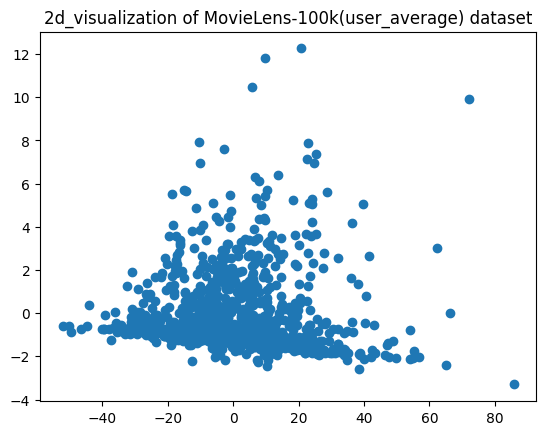

In [5]:
# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

N_DIMENSIONS = 2

pca = PCA(N_DIMENSIONS) # 次元数を設定して初期化
printcipalComponents = pca.fit_transform(X_movie)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
principalValue = principalDf.values # 主成分データ


plt.scatter(principalValue[:,0], principalValue[:,1])
plt.title("2d_visualization of MovieLens-100k(user_average) dataset")
plt.rcParams["font.size"] = 11
plt.savefig(f"ave_movie_2d_visualization.png", format="png", dpi=300)

In [6]:
def RSCCMM(X, C, delta):
  n, m = X.shape
  u = np.zeros((C,n))
  normalized_u = np.zeros((C,n))

  #要素の正規化
  #sys.float_info.epsilon を足してないと、類似度計算の時にlog(0)となってNaNが発生する
  # X = X + sys.float_info.epsilon
  # np.where(X == 0, sys.float_info.epsilon, X)
  normalized_X = X / np.sum(X, 1)[:, np.newaxis]

  #類似度
  s_it = np.array([np.sum(normalized_X * np.log(row + sys.float_info.epsilon), 1) for row in normalized_X])

  #二項関係
  #deltaの値が小さすぎると二項関係がなくなって、(※)式のところでゼロ徐算が発生する
  R = (s_it >= delta).astype(np.float64)

  #初期項目メンバシップ
  w = np.array([X[c] + sys.float_info.epsilon for c in random.sample(range(n), C)])
  w /= w.sum(1)[:,np.newaxis]

  #繰り返し処理
  for i in range(100):
    old_u = normalized_u.copy()
    u = np.zeros((C,n))
    normalized_u = np.zeros((C,n))

    #HCCMM的なクラスター割り当てによるメンバシップ
    s = np.log(w) @ X.T
    s_max = np.max(s, 0)
    u = (s >= s_max).astype(np.float64)

    #粒状性（二項関係）を考慮した上近似メンバシップ
    if(np.any(np.sum(R, 1) == 0)):
       raise Exception("二項関係がない")
    normalized_u = ((u @ R.T) / np.sum(R, 1) > 0).astype(np.float64) #(※)
    normalized_u /= normalized_u.sum(0)

    #正規化メンバシップ更新
    #ここでも微小値を足していないと次の類似度計算の時にNaNになって計算できなくなる
    w = (normalized_u @ X) + sys.float_info.epsilon
    if(np.any(np.isnan(w.sum(1)))):
      raise Exception("NaN発生")
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(normalized_u - old_u).max() == 0:
      break

  return normalized_u.T @ w, (u @ R.T) / np.sum(R, 1)

In [9]:
#roopの回数を指定し、最大のaucとその時のクラスター構造を返す関数(RSCCMM)
from sklearn.metrics import roc_auc_score

def RSCCMM_CF_AUC_CLUSTER(roop, test, X, C, delta):
  n, m = X.shape
  test_num, test_num_fact = test.shape
  auc_max = 0
  rm_max = 0

  test_true = np.zeros(test_num)
  r_test_score = np.zeros(test_num)

  for i in range(test_num):
    test_true[i] = 1 if test[i][2] > 3 else 0

  for i in range(roop):
    r, rm = RSCCMM(X, C, delta) # RSCCM法を適用

    for j in range(test_num):
      r_test_score[j] = r[test[j][0]-1][test[j][1]-1]

    auc = roc_auc_score(test_true, r_test_score) # AUCを計算

    if auc > auc_max:
      auc_max = auc
      rm_max = rm


  return auc_max, rm_max

auc, rm = RSCCMM_CF_AUC_CLUSTER(10, TEST, X_movie, 3, -7.430)
print("auc: ", auc)

auc:  0.7072713047552386


auc_max:  0.7091151328700238
delta_max:  -7.430000000000001


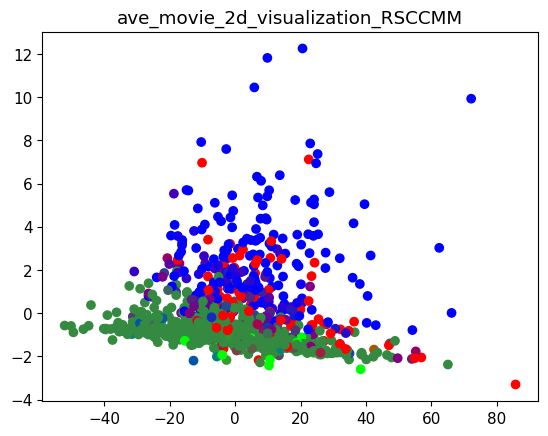

In [10]:
name = "ave_movie_2d_visualization_RSCCMM"
C = 3
loop = 10
delta_list = np.arange(-7.428, -7.432, -0.001)

auc_max = 0
rm_max = 0
delta_max = 0
for delta in delta_list:
  auc, rm = RSCCMM_CF_AUC_CLUSTER(10, TEST, X_movie, C, delta)
  if auc > auc_max:
    auc_max = auc
    rm_max = rm
    delta_max = delta


print("auc_max: ", auc_max)
print("delta_max: ", delta_max)

# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

N_DIMENSIONS = 2

pca = PCA(N_DIMENSIONS) # 次元数を設定して初期化
printcipalComponents = pca.fit_transform(X_movie)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
principalValue = principalDf.values # 主成分データ


plt.scatter(principalValue[:,0], principalValue[:,1], color=rm_max.T)
plt.title(name)
plt.rcParams["font.size"] = 11
plt.savefig(f"{name}.png", format="png", dpi=300)

with open(f'{name}_rough_membership.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(rm_max)

output_info = [["auc", "delta"]]
output_info.append([auc_max, delta_max])
with open(f'{name}_info.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(output_info)